# Cyclic Steam Injection

#### Authors: Lewis Li, Daniel De Brito

In this project, we will simulate the oil production, cumulative oil production and average reservoir temperature as a function of time for several cycles. We will assume that the reservoir properties are known.

## Reservoir Data:

In [1]:
kRes = 1.5;                             % Reservoir permeability (D)
kSteam = 2 * kRes;                      % Permeability to steam (D)
phi = 0.32;                             % Porosity 
Swi = 0.25;                             % Initial water saturation
rw = 0.31;                              % Well radius (ft)
SorSteam = 0.05;                        % Residual oil saturation to steam 
SorWater = 0.25;                        % Residual oil saturation to water 
Tr = 110;                               % Initial reservoir temperature (F)
Tstd = 60;                              % Standard temperature (F) 
lambda = 24;                            % Reservoir thermal conductivity (Btu/ft day F)
alpha = 0.48;                           % Reservoir thermal diffusivity (ft^2/day)
rhoOilStd = 61.8;                       % Oil density @ standard condictions (lb/ft^3)
TimeStep = 1.0;                         % Time step size (days)
PatternArea=0.588;                      % (acres) = well spacing of 160ft
PayThickness = 80;                      % Pay thickness (ft)
g = 32.17;                              % Gravitational acceleration (ft/s^2)

## Operational Data
The operational data is shown below:

In [2]:
SteamInjectionRate = [647 905 953 972 954 1042 1067];      % Steam injection rate (bbl/day)
InjectionTime = [6 9 8 6 6 7 7];                           % Injection time (days)
SoakTime = [5 2 10 12 9 10 11];                            % Soak time (days)
DownHoleSteamTemp = [360 330 330 300 300 300 300];         % Downhole steam temperature (F)
DownHoleSteamQuality = [0.7 0.6 0.5 0.5 0.5 0.5 0.5];      % Downhole steam quality 
ProductionTime = [55 146 79 98 135 136 148];               % Production time (days)
WIP = 50000;                                               % Amount of mobile water in place at beginning of cycle (Assumption)
qw = 0;                                                    % water production rate (BPD) (Assumption)
CumulativeOil = [];                                        % Cumulative oil production (STB) 
CumulativeTime = [];                                       % Cumulative time (days) 
cycleLength = InjectionTime + SoakTime + ProductionTime;   % Total cycle time (days)
cumulativeCycleLength = cumsum([1;cycleLength']);          % Cumulative cycle time (days) 

NumberOfCycles = length(SteamInjectionRate);

## Cycle Initial Conditions
For each steam cycle, we will proceed as follows. We will first demonstrate the simulation on the first cycle, then repeat for the rest of the injection cycles. We will assume that the temperature of the reservoir returns to the original reservoir temperature between each cycle, and we start by evaluating the water enthalpy correction for both the reservoir and the steam using:

$$h_w = 68 \left[ \frac{T_s}{100} \right]^{1.24}$$

In [3]:
CurrentCycleNumber = 1;

% Water enthalpy correlation for reservoir temperature (eq 16)
hwTr = 68 * ( Tr/100 )^1.24;                                  

% Water enthalpy correlation for steam temperature (eq 16)
hwSteam = 68 * ( DownHoleSteamTemp(CurrentCycleNumber) / 100 )^1.24;   

We next evaluate the specific heat quality of water using the Jones relation:
$$C_w = \frac{h_w(T_s) - h_w(T_R)}{T_s-T_R}$$

In [4]:
% Specific heat of water of Jones (eq 15)       
Cw = ( hwSteam - hwTr ) / ( DownHoleSteamTemp(CurrentCycleNumber) - Tr );                

We then compute the steam latent heat correction from Farouq Ali (eq 17)
$$L_{vdh} = 94(705-T_s)^{0.38}$$ 

and then the amount of heat injected per unit mass of steam is:
$$Q_i = C_w(T_s - T_R) + L_{vdh}f_{sdh}$$

In [5]:
% Steam latent heat correlation of Farouq Ali (eq 17)
Lvdh = 94 * ( 705 - DownHoleSteamTemp(CurrentCycleNumber) )^0.38;                  

% Amount of heat injected per unit mass of steam (eq 14)
Qi = Cw * ( DownHoleSteamTemp(CurrentCycleNumber) - Tr ) +...
        Lvdh * DownHoleSteamQuality(CurrentCycleNumber);    

The steam properties are evaluated as:

$$p_{steam} = \left[ \frac{T_s}{115.95}\right]^4.4543$$

$$\rho_{steam} = \frac{p_s^{0.9588}}{363.9}$$

$$\mu_{steam} = 10^{-4}(0.2T_s + 82)$$

In [6]:
% Steam pressure approximation (eq 7)
pSteam = ( DownHoleSteamTemp(CurrentCycleNumber) / 115.95 )^4.4543;                 

% Steam density (eq 10)
rhoSteam = pSteam^( 0.9588 ) / 363.9;                                  

% Steam viscosity (eq 11)
muSteam = 1e-4 * ( 0.2 * DownHoleSteamTemp(CurrentCycleNumber) + 82 );                 

The densities of oil and water are estimated as:
$$\rho_{o} = \rho_{ostd} - 0.0214(T-T_{std})$$

$$\rho_{water} = 62.4 - 11 \log \left( \frac{ 705 - T_{std}}{705 - T} \right) $$

In [7]:
% Oil density approximation (eq 32)
rhoOil = rhoOilStd - 0.0214 * ( Tr - Tstd );                           

% Water density approximation (eq 33) 
rhoWater = 62.4 - 11 * log( ( 705 - Tstd ) / ( 705 - Tr ) );        

Bulk volumetric heat capacity is evaluated as:

$$(\rho C)_t = 32.5 + (4.6 \phi^{0.32} - 2)(10S_{wi} - 1.5)$$


In [8]:
% Bulk volumetric heat capacity of Jones (eq 19)  
cp = 32.5 + (4.6 * phi^0.32 - 2) * (10 * Swi - 1.5);                  

To estimate the steam zone thickness, we first define the dimensionaless group for scaling the radius of the steam zone:

$$A_{RD} = \sqrt{\frac{(350)(144)Q_s\mu_{st}}{6.328(\rho_s - \rho_{std})h_t^2K_{st}\rho_{st}}}$$

Average steam zone thickness by Van Lookeren is then:
$$h_{st} = 0.5 h_t A_{rd}$$

In [9]:
% Dimensionless group for scaling the radial steam zone (eq 9) 
ARD = sqrt( ( 350 * 144 * SteamInjectionRate(CurrentCycleNumber) * muSteam ) / ...      
          ( 6.328 * pi * ( rhoOil - rhoSteam ) * PayThickness^2 * ...
          kSteam * rhoSteam ) ); 
% Average steam zone thickness by Van Lookeren (eq 8)            
hSt = 0.5 * PayThickness * ARD;                                        

% Cumulative water production at beginning of cycle
Wp = 0.0;                                                              

Evaluate how much heat is in the reservoir from previous cycles
$$ H_{last} = V_s(\rho C)_t(T_{avg}-T_R) $$

In [10]:
  % Figure out how much heat is already in the reservoir
    if(CurrentCycleNumber==1)
        Hlast = 0;        
    else
        % Amount of heat in the reservoir for subsequent cycles (eq 20)
        Hlast = VSteam * cp * (Taverage - Tr);                            
    end
    
    %% Evaluate water and steam thermodynamic properties
    % Water enthalpy correlation for reservoir temperature (eq 16)
    hwTr = 68 * ( Tr/100 )^1.24;                              
    
    % Water enthalpy correlation for steam temperature (eq 16)
    hwSteam = 68 * ( DownHoleSteamTemp(CurrentCycleNumber) / 100 )^1.24;                    
    
    % Specific heat of water of Jones (eq 15)
    Cw = ( hwSteam - hwTr ) / ( DownHoleSteamTemp(CurrentCycleNumber) - Tr );        

    % Steam latent heat correlation of Farouq Ali (eq 17)
    Lvdh = 94 * ( 705 - DownHoleSteamTemp(CurrentCycleNumber) )^0.38;                      
    
    % Amount of heat injected per unit mass of steam (eq 14)
    Qi = Cw * ( DownHoleSteamTemp(CurrentCycleNumber) - Tr ) +...
        Lvdh * DownHoleSteamQuality(CurrentCycleNumber);                      
    
    % Amount of heat injected (eq 28)
    HeatInjected = 350 * Qi * SteamInjectionRate(CurrentCycleNumber)...
        * InjectionTime(CurrentCycleNumber);
        
    % Steam pressure approximation (eq 7)
    pSteam = ( DownHoleSteamTemp(CurrentCycleNumber) / 115.95 )^4.4543;                 
    
    % Steam density (eq 10)
    rhoSteam = pSteam^( 0.9588 ) / 363.9;                                  
    
    % Steam viscosity (eq 11)
    muSteam = 1e-4 * ( 0.2 * DownHoleSteamTemp(CurrentCycleNumber) + 82 );                  
    

The steam zone volume is estimated as
$$ V_s = \frac{Q_s t_{inj} \rho_w Q_i + H_{last}}{(\rho c)_t (T_s - T_R)}$$

The radius of the steam zone is:
$$R_h = \sqrt{\frac{V_s}{\pi h_{st}}}$$

In [11]:
    %% Evaluating the steam zone size
    % Oil density approximation (eq 32)
    rhoOil = rhoOilStd - 0.0214 * ( Tr - Tstd );          
  
    % Dimensionless group for scaling the radial steam zone (eq 9)
    ARD = sqrt( ( 350 * 144 * SteamInjectionRate(CurrentCycleNumber) * muSteam ) / ...     
        ( 6.328 * pi * ( rhoOil - rhoSteam ) * PayThickness^2 * ...
        kSteam * rhoSteam ) );
    
    % Average steam zone thickness by Van Lookeren (eq 8)
    hSt = 0.5 * PayThickness * ARD;             
    
    % Steam zone volume estimation (eq 13)
    VSteam = ( SteamInjectionRate(CurrentCycleNumber) * ...
        InjectionTime(CurrentCycleNumber) * rhoWater * Qi...
        + Hlast ) / ( cp * ( DownHoleSteamTemp(CurrentCycleNumber) - Tr ) );
    % Steam zone radius (eq 12)
    RhSteam = sqrt( VSteam / ( pi * hSt ) );       
    
    % Radial distance along the hot oil zone (eq 2)
    Rx = sqrt( RhSteam^2 + PayThickness^2 );       
    
    % theta = angle between steam-oil interface and reservoir bed (eq 5)
    sinTheta = PayThickness / Rx;                                   
    
    % Difference between height of reservoir and steam zone thickness, (eq 6)
    deltaH= PayThickness - hSt;  
    
    % Bottom hole flowing pressure (assumption)
    pwf = 0.6 * pSteam ;                       
    
    % Change in enthalpy (equation 4)
    deltaPhi = deltaH * g * sinTheta + ( ( ( pSteam - pwf )...      
        * 6895 )/ ( rhoOil * 16.02 ) ) * 10.76;
    
    % Change in oil saturation (eq 3)
    deltaSo = ( 1 - Swi ) - SorSteam;                           

In [12]:
%% Estimate relative permeability of water and oil
% Cumulative water production at beginning of cycle
Wp = 0.0;                                                              
% Volumetric heat capacity of water (eq 31)
Mwater = Cw * rhoWater;                                         
% Mobile water around the well (eq 38)
SwBar = 1 - SorWater;                                           
% Water saturation  (eq 39)
Sw = SwBar - (SwBar - Swi) * Wp / WIP;                          
% Normalized water saturation (eq 40)
SwStar = (Sw - Swi)/(1 - Swi - SorWater);                       
% Water relative permeability (eq 41)
krw = -0.002167 * SwStar + 0.024167 * SwStar^2;     

% Oil relative permeability (eq 43)
if SwStar <= 0.2
    kro = 1.0;                                                 
else
    % Oil relative permeability (eq 42)
    kro = -0.9416 + 1.0808 / SwStar - 0.13858 / SwStar^2;     
end

We now are ready to proceed through the cycle, and simulate what occurs during the injection interval, soaking interval, and production interval.

In [13]:
% Oil rate vector
qoPreviousCycle = zeros(cycleLength(CurrentCycleNumber),1);                            
    
% Average temperature vector
TaveragePreviousCycle = zeros(cycleLength(CurrentCycleNumber),1);                       
    

### Injection Interval
During the injection interval the average temperature during injection = downhole steam temperature ($T_{avg} = T_s$), and of course no oil is being produced yet $q_o = 0$

### Soaking Interval
During the soaking interval, the Boberg and Lantz equations are used to evaluate the average temperature. This assumes a cylindrical shape for the heated zone. 

$$T_{avg} = T_R + (T_s - T_R) \left[ f_{HD} f_{VD} (1-f_{PD}) - f_{PD} \right ]$$

The dimensionless parameters $f$ present the radial loss, vertical loss and energy removed from produced fluids. The radial loss is evaluated as:
$$ f_{HD} = \frac{1}{1+t_{DH}}$$
where
$$ t_{DH} = \frac{\alpha(t-t_{inj}}{R_h^2}$$
The vertical loss is 
$$ f_{VD} = \frac{1}{\sqrt{1+5t_{DV}}}$$
where
$$ t_{DV} = \frac{4\alpha(t-t_{inj}}{h_t^2}$$

No oil is being produced in the soaking interval either $q_o = 0$

### Production Interval
During the production interval, the average temperature is computed the same way as during the soaking interval. The oil rate is more complicated to evaluate. We start by calculating the volumetric heat capacity of oil:

$$M_o = (3.085 + 0.00355T)\sqrt{\rho_o}$$

Using this, we can evaluate the rat of heat removal from the reservoir with the produced fluids
$$ Q_p = 5.616(q_oM_o + q_wM_w)(T_{avg}- T_R) $$

The maximum amount of heat that is removed from the reservoir is given by:

$$Q_{max} = H_{inj} + H_{last} - \pi R_h^2K_R(T_s-T_R) \sqrt{\frac{T_{soak}}{\pi \alpha}} $$

The energy removed from the by the fluid is:

$$f^n_{PD} = (f^b_{PD})^{-1} + \Delta f_{PD} $$

where 

$$\Delta f_{PD} = \frac{5.615(q_oM_o + q_wM_w)(T^{n-1}_{avg} - T_R)\Delta t}{2Q_{max}}$$

Finally, we evaluate the updated oil viscosity:

$$\nu_o = \alpha e^{\frac{b}{T+480}} $$

Now we have all the terms to evaluate the oil rate:

$$q_o = 1.87 R_o \sqrt{\frac{K_o \phi \Delta S_o \alpha \Delta \phi}{m_o \nu_{avg} [ln \frac{R_s}{r_w} - 0.5]}}$$


In [14]:
 % Cycling through InjectionTime + SoakTime + ProductionTime
    for t = 1:cycleLength(CurrentCycleNumber)                                               
        
        % Injection Interval
        if t <= (InjectionTime(CurrentCycleNumber))                                         
            %Average temperature during injection = downhole steam temperature
            Taverage = DownHoleSteamTemp(CurrentCycleNumber);                               
            qo = 0;
            
        end
        
        % Soaking interval
        if t > InjectionTime(CurrentCycleNumber) && ...
                t <= (InjectionTime(CurrentCycleNumber) + ...
                SoakTime(CurrentCycleNumber))  
            
            % Radial loss (eq 22)
            tDH = alpha * ( t - InjectionTime(CurrentCycleNumber) )...
                / RhSteam^2;             
            fHD = 1 / ( 1 + 5 * tDH );                                      
            
            % Vertical loss (eq 23)
            tDV = 4 * alpha * ( t - InjectionTime(CurrentCycleNumber) ) ...
                / PayThickness^2;    
            fVD = 1 / sqrt( 1 + 5 * tDV );                                  
            
            % Energy removed with produced fluids during soaking phase
            fPD = 0;                       
            
            % Oil rate during soaking phase
            qo = 0;                                                         
            
            % Average temperature at any time by Boberg and Lantz (eq 21)
            TpreviousTimeStep = Taverage;
            Taverage = Tr + ( DownHoleSteamTemp(CurrentCycleNumber) ...                      
                - Tr ) * ( fHD * fVD * ( 1 - fPD ) - fPD );
        end
        
        % Production Interval
        if t > (InjectionTime(CurrentCycleNumber) + SoakTime(CurrentCycleNumber))                            

            %Radial loss (eq 22)
            tDH  = alpha * ( t - InjectionTime(CurrentCycleNumber) )...
                / RhSteam^2;           
            fHD = 1 / ( 1 + 5 * tDH );                                     
            
            % Vertical loss (eq 23)
            tDV = 4 * alpha * ( t - InjectionTime(CurrentCycleNumber) )...
                / PayThickness^2;   
            fVD = 1 / sqrt( 1 + 5 * tDV );                                  
            
            % Registering average temperature from previous time step
            TpreviousTimeStep = Taverage;                                  
            
            % Average temperature at any time by Boberg and Lantz (eq 21)
            Taverage = Tr + ( DownHoleSteamTemp(CurrentCycleNumber) ...                      
                - Tr ) * ( fHD * fVD * ( 1 - fPD ) - fPD );
            
            % Volumetric heat capacity of oil (eq 30)
            Moil = ( 3.065 + 0.00355 * Taverage ) * sqrt( rhoOil );
            
            % Rate of heat removal from the reservoir with produced fluids (eq 29)
            Qp = 5.615 * ( qo * Moil + qw * Mwater )*( Taverage - Tr );
            
            % Maximum amount of heat supplied to the reservoir (eq 27)
            Qmax = HeatInjected + Hlast - pi * RhSteam^2 * lambda...
                * (DownHoleSteamTemp(CurrentCycleNumber) - Tr) * ...
                sqrt(SoakTime(CurrentCycleNumber)/(pi*alpha));
                       
            % Energy removed with produced fluids (eq 34)
            fPD  = fPD + 5.615 * ( qo * Moil + qw * Mwater )...
                * ( TpreviousTimeStep - Tr ) * TimeStep / ( 2 * Qmax );;
            
            % Oil viscosity (eq 36)
            muOil = ( 2.698e-5 ) * exp( ( 1.066e+4 ) /( Taverage + 460 ));
            
            % Kinematic viscosity of the oil = oil viscosity/oil density
            nuAverage = muOil / rhoOil;
            
            % Oil rate (eq 1)
            qo = 1.87 * Rx * sqrt ( ( kro * kRes * phi * deltaSo...
                * alpha * deltaPhi )/( 2.0  *nuAverage...
                * ( log( Rx / rw ) - 0.5 ) ) );
        end
        
        qoPreviousCycle(t) = qo;
        TaveragePreviousCycle(t) = Taverage;
        
    end
   

## Repeat For All Cycles
We can repeat this for all cycles specified above, just with a for-loop.

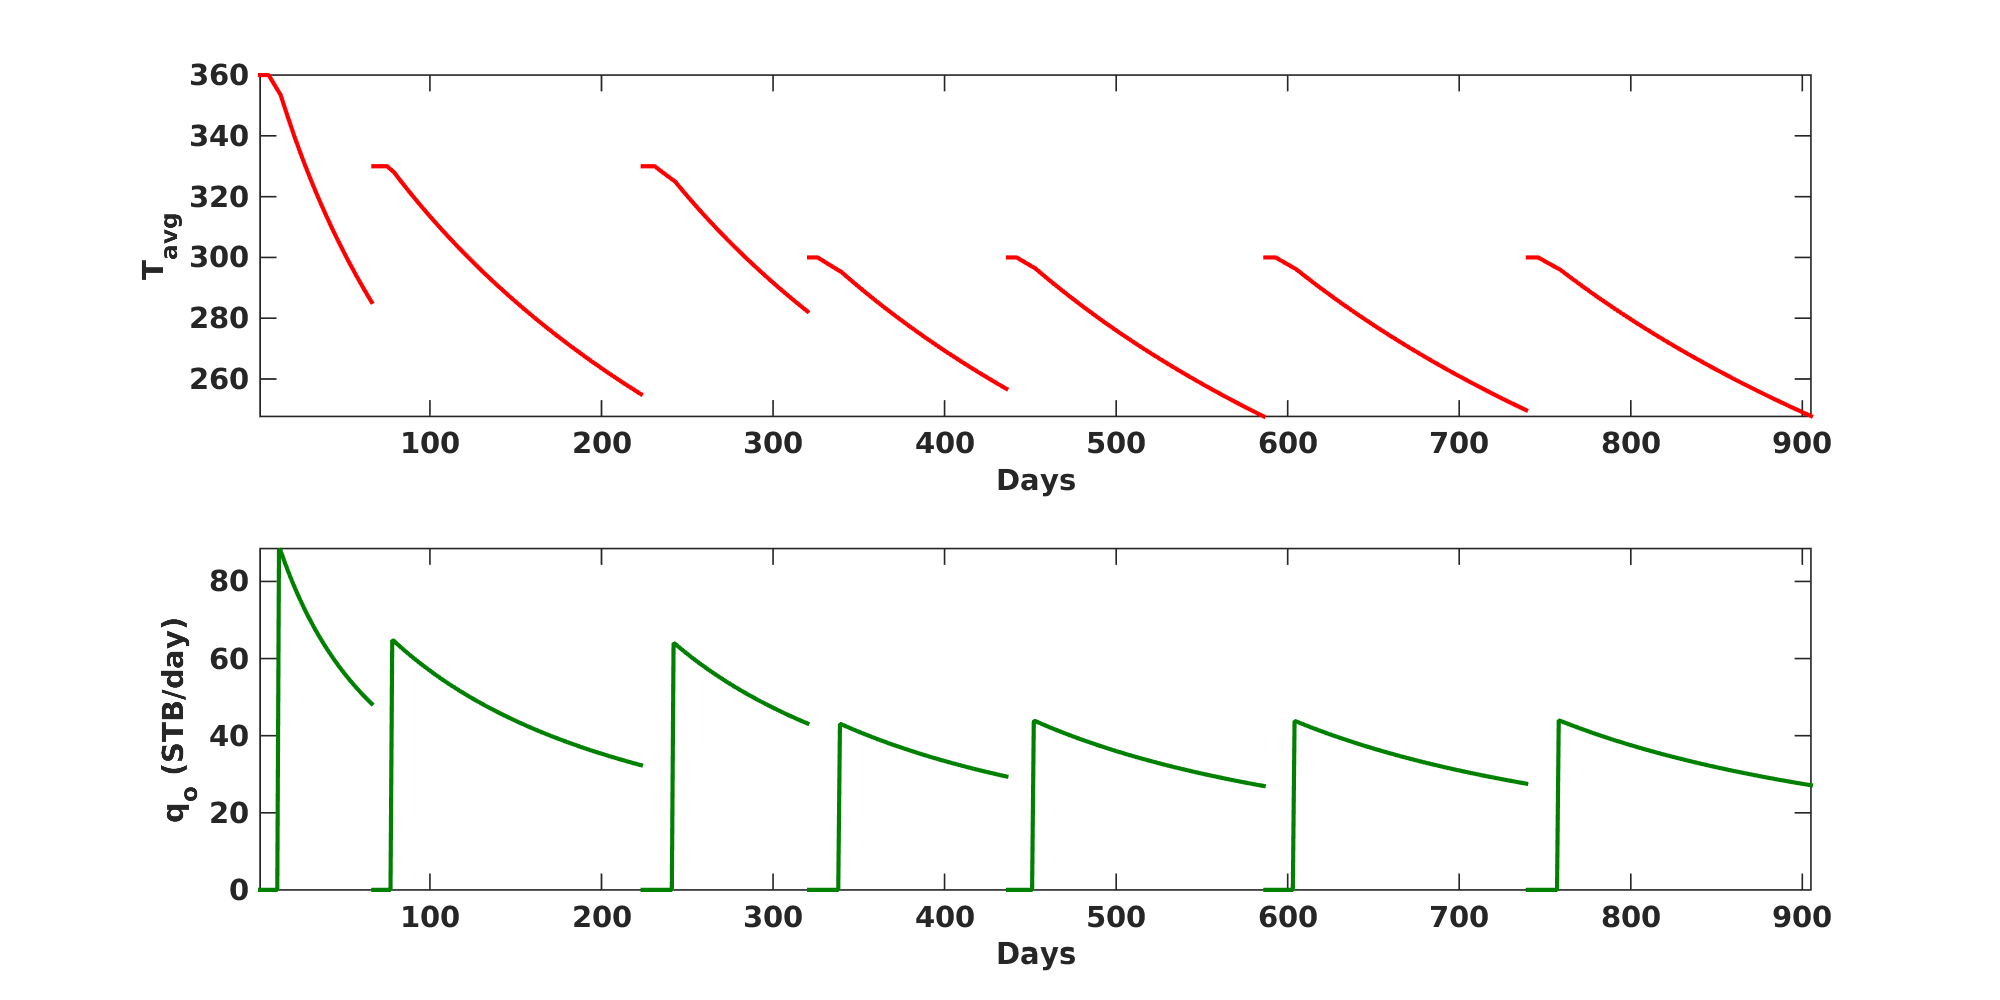

In [15]:
%plot inline -s 2000,1000
for CurrentCycleNumber=1:length(SteamInjectionRate)
    
    % Time at beginning of each cycle
    t=0;          
    
    % Figure out how much heat is already in the reservoir
    if(CurrentCycleNumber==1)
        Hlast = 0;        
    else
        % Amount of heat in the reservoir for subsequent cycles (eq 20)
        Hlast = VSteam * cp * (Taverage - Tr);                            
    end
    
    %% Evaluate water and steam thermodynamic properties
    % Water enthalpy correlation for reservoir temperature (eq 16)
    hwTr = 68 * ( Tr/100 )^1.24;                              
    
    % Water enthalpy correlation for steam temperature (eq 16)
    hwSteam = 68 * ( DownHoleSteamTemp(CurrentCycleNumber) / 100 )^1.24;                    
    
    % Specific heat of water of Jones (eq 15)
    Cw = ( hwSteam - hwTr ) / ( DownHoleSteamTemp(CurrentCycleNumber) - Tr );        

    % Steam latent heat correlation of Farouq Ali (eq 17)
    Lvdh = 94 * ( 705 - DownHoleSteamTemp(CurrentCycleNumber) )^0.38;                      
    
    % Amount of heat injected per unit mass of steam (eq 14)
    Qi = Cw * ( DownHoleSteamTemp(CurrentCycleNumber) - Tr ) +...
        Lvdh * DownHoleSteamQuality(CurrentCycleNumber);                      
    
    % Amount of heat injected (eq 28)
    HeatInjected = 350 * Qi * SteamInjectionRate(CurrentCycleNumber)...
        * InjectionTime(CurrentCycleNumber);
        
    % Steam pressure approximation (eq 7)
    pSteam = ( DownHoleSteamTemp(CurrentCycleNumber) / 115.95 )^4.4543;                 
    
    % Steam density (eq 10)
    rhoSteam = pSteam^( 0.9588 ) / 363.9;                                  
    
    % Steam viscosity (eq 11)
    muSteam = 1e-4 * ( 0.2 * DownHoleSteamTemp(CurrentCycleNumber) + 82 );                  
    
    %% Evaluating the steam zone size
    % Oil density approximation (eq 32)
    rhoOil = rhoOilStd - 0.0214 * ( Tr - Tstd );          
  
    % Dimensionless group for scaling the radial steam zone (eq 9)
    ARD = sqrt( ( 350 * 144 * SteamInjectionRate(CurrentCycleNumber) * muSteam ) / ...     
        ( 6.328 * pi * ( rhoOil - rhoSteam ) * PayThickness^2 * ...
        kSteam * rhoSteam ) );
    
    % Average steam zone thickness by Van Lookeren (eq 8)
    hSt = 0.5 * PayThickness * ARD;             
    
    % Steam zone volume estimation (eq 13)
    VSteam = ( SteamInjectionRate(CurrentCycleNumber) * ...
        InjectionTime(CurrentCycleNumber) * rhoWater * Qi...
        + Hlast ) / ( cp * ( DownHoleSteamTemp(CurrentCycleNumber) - Tr ) );
    % Steam zone radius (eq 12)
    RhSteam = sqrt( VSteam / ( pi * hSt ) );       
    
    % Radial distance along the hot oil zone (eq 2)
    Rx = sqrt( RhSteam^2 + PayThickness^2 );       
    
    % theta = angle between steam-oil interface and reservoir bed (eq 5)
    sinTheta = PayThickness / Rx;                                   
    
    % Difference between height of reservoir and steam zone thickness, (eq 6)
    deltaH= PayThickness - hSt;  
    
    % Bottom hole flowing pressure (assumption)
    pwf = 0.6 * pSteam ;                       
    
    % Change in enthalpy (equation 4)
    deltaPhi = deltaH * g * sinTheta + ( ( ( pSteam - pwf )...      
        * 6895 )/ ( rhoOil * 16.02 ) ) * 10.76;
    
    % Change in oil saturation (eq 3)
    deltaSo = ( 1 - Swi ) - SorSteam; 
    
    %% Estimate relative permeability of water and oil
    % Cumulative water production at beginning of cycle
    Wp = 0.0;                                                              
    % Volumetric heat capacity of water (eq 31)
    Mwater = Cw * rhoWater;                                         
    % Mobile water around the well (eq 38)
    SwBar = 1 - SorWater;                                           
    % Water saturation  (eq 39)
    Sw = SwBar - (SwBar - Swi) * Wp / WIP;                          
    % Normalized water saturation (eq 40)
    SwStar = (Sw - Swi)/(1 - Swi - SorWater);                       
    % Water relative permeability (eq 41)
    krw = -0.002167 * SwStar + 0.024167 * SwStar^2;           
    
    % Oil relative permeability (eq 43)
    if SwStar <= 0.2
        kro = 1.0;                                                 
    else
        % Oil relative permeability (eq 42)
        kro = -0.9416 + 1.0808 / SwStar - 0.13858 / SwStar^2;     
    end
    
    % Oil rate vector
    qoPreviousCycle = zeros(cycleLength(CurrentCycleNumber),1);                            
    
    % Average temperature vector
    TaveragePreviousCycle = zeros(cycleLength(CurrentCycleNumber),1);                       
    
    % Cycling through InjectionTime + SoakTime + ProductionTime
    for t = 1:cycleLength(CurrentCycleNumber)                                               
        
        % Injection Interval
        if t <= (InjectionTime(CurrentCycleNumber))                                         
            %Average temperature during injection = downhole steam temperature
            Taverage = DownHoleSteamTemp(CurrentCycleNumber);                               
            qo = 0;
            
        end
        
        % Soaking interval
        if t > InjectionTime(CurrentCycleNumber) && ...
                t <= (InjectionTime(CurrentCycleNumber) + ...
                SoakTime(CurrentCycleNumber))  
            
            % Radial loss (eq 22)
            tDH = alpha * ( t - InjectionTime(CurrentCycleNumber) )...
                / RhSteam^2;             
            fHD = 1 / ( 1 + 5 * tDH );                                      
            
            % Vertical loss (eq 23)
            tDV = 4 * alpha * ( t - InjectionTime(CurrentCycleNumber) ) ...
                / PayThickness^2;    
            fVD = 1 / sqrt( 1 + 5 * tDV );                                  
            
            % Energy removed with produced fluids during soaking phase
            fPD = 0;                       
            
            % Oil rate during soaking phase
            qo = 0;                                                         
            
            % Average temperature at any time by Boberg and Lantz (eq 21)
            TpreviousTimeStep = Taverage;
            Taverage = Tr + ( DownHoleSteamTemp(CurrentCycleNumber) ...                      
                - Tr ) * ( fHD * fVD * ( 1 - fPD ) - fPD );
        end
        
        % Production Interval
        if t > (InjectionTime(CurrentCycleNumber) + SoakTime(CurrentCycleNumber))                            

            %Radial loss (eq 22)
            tDH  = alpha * ( t - InjectionTime(CurrentCycleNumber) )...
                / RhSteam^2;           
            fHD = 1 / ( 1 + 5 * tDH );                                     
            
            % Vertical loss (eq 23)
            tDV = 4 * alpha * ( t - InjectionTime(CurrentCycleNumber) )...
                / PayThickness^2;   
            fVD = 1 / sqrt( 1 + 5 * tDV );                                  
            
            % Registering average temperature from previous time step
            TpreviousTimeStep = Taverage;                                  
            
            % Average temperature at any time by Boberg and Lantz (eq 21)
            Taverage = Tr + ( DownHoleSteamTemp(CurrentCycleNumber) ...                      
                - Tr ) * ( fHD * fVD * ( 1 - fPD ) - fPD );
            
            % Volumetric heat capacity of oil (eq 30)
            Moil = ( 3.065 + 0.00355 * Taverage ) * sqrt( rhoOil );
            
            % Rate of heat removal from the reservoir with produced fluids (eq 29)
            Qp = 5.615 * ( qo * Moil + qw * Mwater )*( Taverage - Tr );
            
            % Maximum amount of heat supplied to the reservoir (eq 27)
            Qmax = HeatInjected + Hlast - pi * RhSteam^2 * lambda...
                * (DownHoleSteamTemp(CurrentCycleNumber) - Tr) * ...
                sqrt(SoakTime(CurrentCycleNumber)/(pi*alpha));
                       
            % Energy removed with produced fluids (eq 34)
            fPD  = fPD + 5.615 * ( qo * Moil + qw * Mwater )...
                * ( TpreviousTimeStep - Tr ) * TimeStep / ( 2 * Qmax );;
            
            % Oil viscosity (eq 36)
            muOil = ( 2.698e-5 ) * exp( ( 1.066e+4 ) /( Taverage + 460 ));
            
            % Kinematic viscosity of the oil = oil viscosity/oil density
            nuAverage = muOil / rhoOil;
            
            % Oil rate (eq 1)
            qo = 1.87 * Rx * sqrt ( ( kro * kRes * phi * deltaSo...
                * alpha * deltaPhi )/( 2.0  *nuAverage...
                * ( log( Rx / rw ) - 0.5 ) ) );
        end
        
        qoPreviousCycle(t) = qo;
        TaveragePreviousCycle(t) = Taverage;
        
    end
    
    CumulativeOil = [ CumulativeOil ; qoPreviousCycle ];
    time_range = linspace( cumulativeCycleLength(CurrentCycleNumber) , ...
    cumulativeCycleLength(CurrentCycleNumber+1) , ...
    (cumulativeCycleLength(CurrentCycleNumber+1) - ...
    cumulativeCycleLength(CurrentCycleNumber)) );
    CumulativeTime = [ CumulativeTime ; time_range' ];
    
    %Plotting production
    subplot(2,1,2)
    plot([cumulativeCycleLength(CurrentCycleNumber):1:...
    (cumulativeCycleLength(CurrentCycleNumber+1)')-1],...
    qoPreviousCycle,'-','Color',[0 0.5 0],'LineWidth',2);
    hold on;
    xlabel('Days','FontSize',14,'FontWeight','bold');
    ylabel('q_o (STB/day)','FontSize',14,'FontWeight','bold');
    set(gca,'FontSize',14,'FontWeight','bold');
    axis tight;
    
    % Plotting temperature
    subplot(2,1,1);
    plot([cumulativeCycleLength(CurrentCycleNumber):1:...
    (cumulativeCycleLength(CurrentCycleNumber+1)')-1],...
    TaveragePreviousCycle,'r-','LineWidth',2);
    hold on;
    xlabel('Days','FontSize',14,'FontWeight','bold')
    ylabel('T_{avg}','FontSize',14,'FontWeight','bold')
    set(gca,'FontSize',14,'FontWeight','bold');
    axis tight;
    
    clear Tavg_saved qo_saved;    
end

We can also plot the cumulative oil production below:

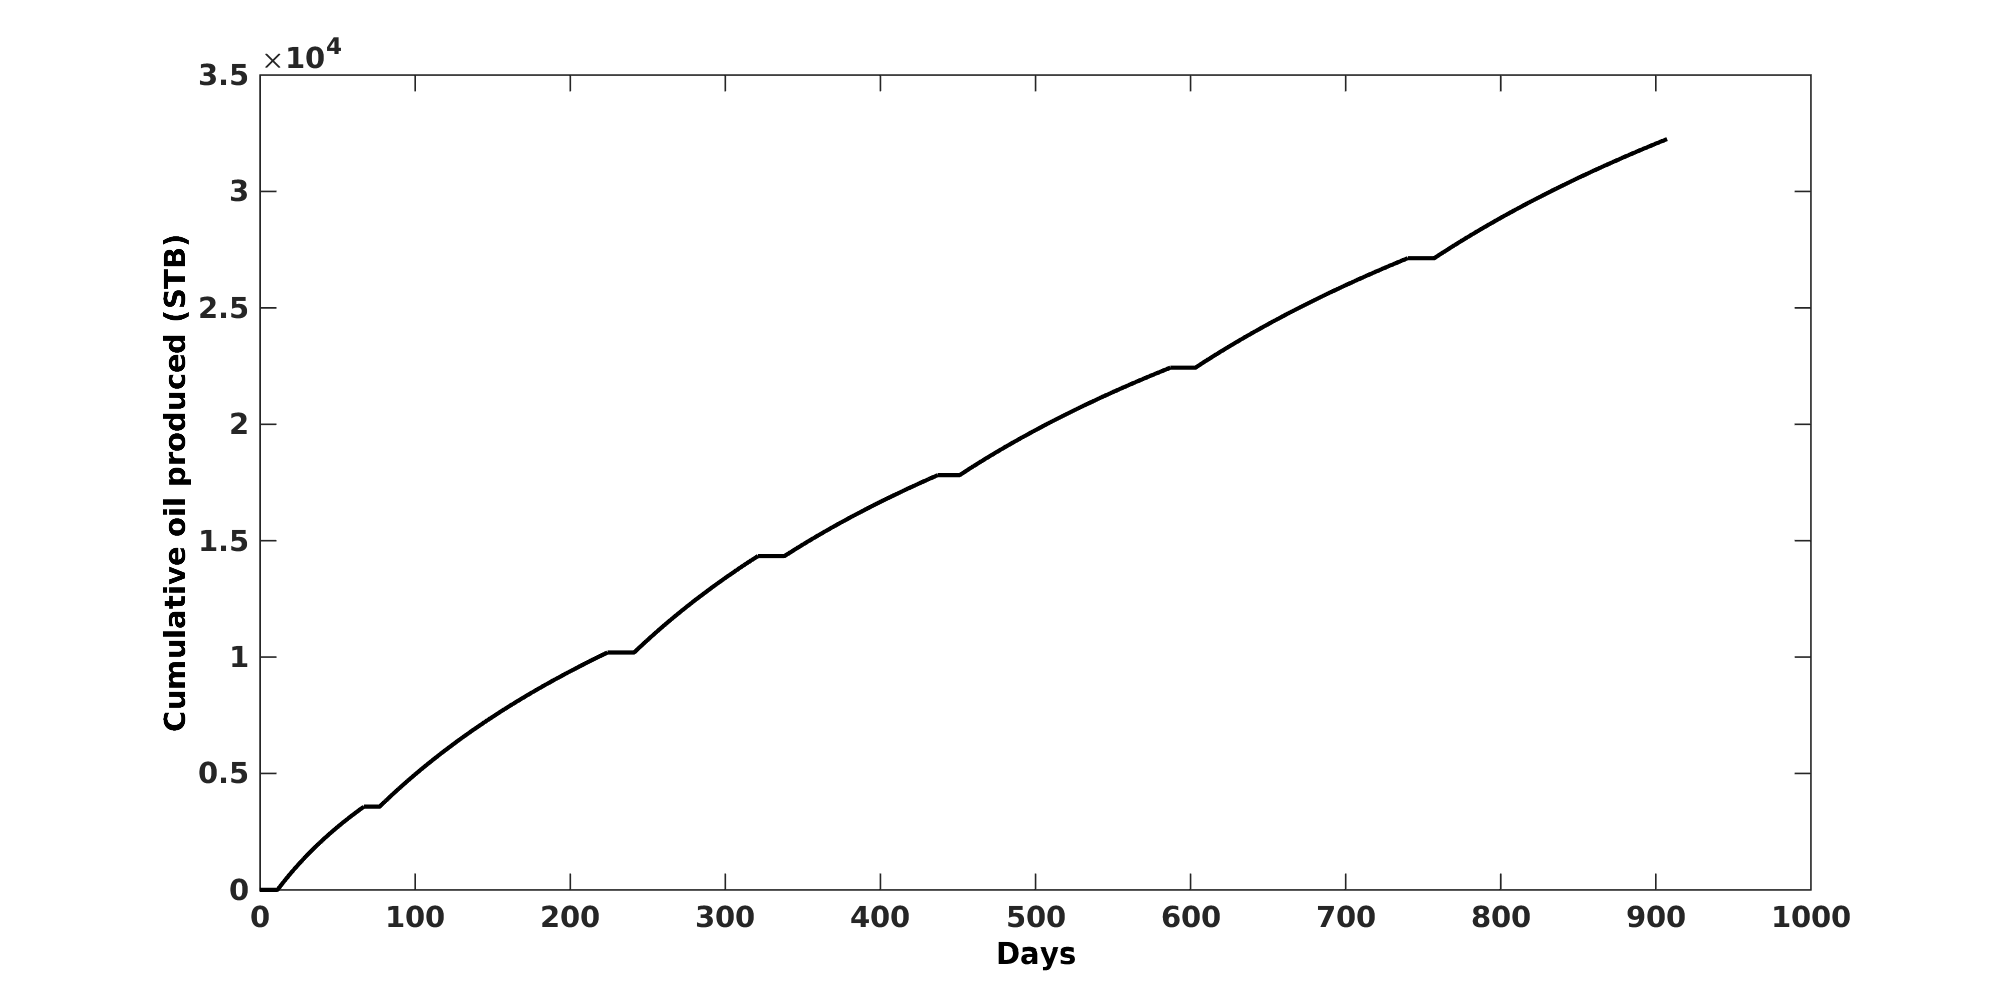

In [16]:
% Plotting cumulative oil production
figure('Color','w');
set(gcf, 'Position', get(0,'Screensize'));
plot(CumulativeTime,cumsum(CumulativeOil),'-','Color','k','LineWidth',2);
xlabel('Days','FontSize',14,'FontWeight','bold','Color','k')
ylabel('Cumulative oil produced (STB)','FontSize',14,'FontWeight','bold','Color','k')
set(gca,'FontSize',14,'FontWeight','bold');
